In [1]:
import os
import math
import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
def VariableMaker(inputs):
    ''' 
    Takes the list of supercells corresponding to an eFEX 
    processing window and constructs additional variables 
    using them. 
    Returns list of sums calculated from them

    inputs = copy of the SuperCells_ET vector for an RoI
    '''

    '''
    The SuperCell_ET variable in the root file contains a vector of 99 supercells for each RoI
    To understand its contents, consider that the algorithm window in the eFEX is based on 3x3 
    towers, each tower containing 11 supercells:
    
       1 Presampler, 4 Layer 1, 4 Layer 2, 1 Layer 3, 1 Hadronic
       
    Think of the towers being numbered as below:

       -------------
       | 6 | 7 | 8 |
       -------------
       | 3 | 4 | 5 |
       -------------
       | 0 | 1 | 2 |
       -------------

    where eta increases from left to right and phi increases from bottom to top.
    Within each tower the cells are ordered as above (PS, EM1, EM2, EM3, Had),
    and where there are 4 cells in a layer they are ordered in increasing eta.

    In the new supercell array the cells are ordered by eta, then phi, then layer.
    Hence the first 9 cells are the presampler, the next 36 are EM1, then 36 EM2, 
    then 9 EM3 and finally 9 Hadronic. This gives the following mapping:

    ----------- SuperCells eta, phi, layer coordinates ----------------------
     0:{0, 0, 0}, 1:{1, 0, 0}, 2:{2, 0, 0},  
     3:{0, 1, 0}, 4:{1, 1, 0}, 5:{2, 1, 0},
     6:{0, 2, 0}, 7:{1, 2, 0}, 8:{2, 2, 0},  
     9:{0, 0, 1}, 10:{1, 0, 1}, 11:{2, 0, 1}, 12:{3, 0, 1}, 13:{4, 0, 1}, 14:{5, 0, 1},  15:{6, 0, 1}, 16:{7, 0, 1}, 17:{8, 0, 1}, 18:{9, 0, 1}, 19:{10, 0, 1}, 20:{11, 0, 1}, 
    21:{0, 1, 1}, 22:{1, 1, 1}, 23:{2, 1, 1}, 24:{3, 1, 1}, 25:{4, 1, 1}, 26:{5, 1, 1},  27:{6, 1, 1}, 28:{7, 1, 1}, 29:{8, 1, 1}, 30:{9, 1, 1}, 31:{10, 1, 1}, 32:{11, 1, 1}, 
    33:{0, 2, 1}, 34:{1, 2, 1}, 35:{2, 2, 1}, 36:{3, 2, 1}, 37:{4, 2, 1}, 38:{5, 2, 1},  39:{6, 2, 1}, 40:{7, 2, 1}, 41:{8, 2, 1}, 42:{9, 2, 1}, 43:{10, 2, 1}, 44:{11, 2, 1}, 
    45:{0, 0, 2}, 46:{1, 0, 2}, 47:{2, 0, 2}, 48:{3, 0, 2}, 49:{4, 0, 2}, 50:{5, 0, 2},  51:{6, 0, 2}, 52:{7, 0, 2}, 53:{8, 0, 2}, 54:{9, 0, 2}, 55:{10, 0, 2}, 56:{11, 0, 2}, 
    57:{0, 1, 2}, 58:{1, 1, 2}, 59:{2, 1, 2}, 60:{3, 1, 2}, 61:{4, 1, 2}, 62:{5, 1, 2},  63:{6, 1, 2}, 64:{7, 1, 2}, 65:{8, 1, 2}, 66:{9, 1, 2}, 67:{10, 1, 2}, 68:{11, 1, 2}, 
    69:{0, 2, 2}, 70:{1, 2, 2}, 71:{2, 2, 2}, 72:{3, 2, 2}, 73:{4, 2, 2}, 74:{5, 2, 2},  75:{6, 2, 2}, 76:{7, 2, 2}, 77:{8, 2, 2}, 78:{9, 2, 2}, 79:{10, 2, 2}, 80:{11, 2, 2}, 
    81:{0, 0, 3}, 82:{1, 0, 3}, 83:{2, 0, 3},
    84:{0, 1, 3}, 85:{1, 1, 3}, 86:{2, 1, 3},  
    87:{0, 2, 3}, 88:{1, 2, 3}, 89:{2, 2, 3},
    90:{0, 0, 4}, 91:{1, 0, 4}, 92:{2, 0, 4},  
    93:{0, 1, 4}, 94:{1, 1, 4}, 95:{2, 1, 4},
    96:{0, 2, 4}, 97:{1, 2, 4}, 98:{2, 2, 4}; 

    This mapping is actually easier to use for many purposes than the earlier one:
      One of the common things we do is compare or sum neighbouring cells in the same layer. 
      With the earlier mapping you had 4 cells in the same tower in EM1 or EM2, then had to 
      jump to the opposite edge of the neighbouring tower (so jump by 11 places to change tower 
      plus/minus 3 to move to the other side of that tower). Here you only need to worry about
      tower edges when you reach the end of a row. So for example a seed algorithm can compare 
      with cells to the left and right without having to check whether you are at the edge of a tower.
       
       
    '''

    # Mapping cells in "inputs" to tower, layer, cell: 
    '''
      Each of the vectors below contains indices of cells in a given layer in the "inputs" array.

        map0[n] = index of presampler cell in tower n
        map3[n], mapH[n] = indices for EM3 and hadronic cells in tower n
        
      For layer 1 and 2, where there are 4 cells/tower, the first 4 in each map = tower 0, 
      next 4 = tower 1, etc. So if you want the position of supercell X (0-3) from tower n (0-8)
      for these layers it is:
        map1[(n*11)+X] or map1[(n*11)+X]
    '''
    
    map0 = [0,1,2,3,4,5,6,7,8]    
    map1 = [9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44]
    map2 = [45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80]    
    map3 = [81,82,83,84,85,86,87,88,89]    
    mapH = [90,91,92,93,94,95,96,97,98]    

    # Need to find seed cell in central tower.

    # Full seed finding
    seedET = -1
    seedCell = -1
    for sc in range(4):
        cell     = 16 + sc            # Index of seed candidate in central tower of map2
        cellET   = inputs[map2[cell]]       # ET of seed candidate 
        cellETL  = inputs[map2[cell - 1]]  # Neighbours to left/right (eta)
        cellETR  = inputs[map2[cell + 1]]
        cellETU  = inputs[map2[cell + 12]] # Neighbours above/below (phi)
        cellETD  = inputs[map2[cell - 12]]
        cellETLD = inputs[map2[cell - 13]] # diagonal neighbours
        cellETLU = inputs[map2[cell + 11]] 
        cellETRD = inputs[map2[cell - 11]] 
        cellETRU = inputs[map2[cell + 13]] 
        # Cell = seed if ET >= neighbours to left and down, > neighbours to right and up
        if cellET >= cellETLU and cellET >= cellETL and cellET >= cellETLD and cellET >= cellETD and cellET > cellETU  and cellET >  cellETRU and cellET > cellETR and cellET > cellETRD:
           # Keep if this is most energetic seed, or right-most if 2 are equal
           if cellET >= seedET:
               seedET   = cellET
               seedCell = sc

    # Check that it found a seed (should always be true)
    if seedCell < 0:
        print("Error: no seed found!")
        return 0,0,0            
            
    # Now apply UnD logic
    seed = 16 + seedCell    
    UnD = 1 if inputs[map2[seed+12]] >= inputs[map2[seed-12]] else 0

    # Have the seed, now can form some sums.
    # This gives the seed cell position in map2 and corresponding position in map1
    # (In the other layers it's just cell 4, the central cell in a vector of 9)
    iSeed = seedCell+16 
    
    # Sanity check: build the trigger cluster
    
    # Low-granularity layers: 1x2 cells (eta x phi)
    clus0 = inputs[map0[4]] + (inputs[map0[7]] if UnD > 0 else inputs[map0[1]])
    clus3 = inputs[map3[4]] + (inputs[map3[7]] if UnD > 0 else inputs[map3[1]])
    # High-granularity layers: 3x2 cells (etx x phi)
    clus1 = 0
    clus2 = 0
    for off in range(-1,2):
        cell = iSeed + off
        cellN = cell+12 if UnD > 0 else cell - 12
        clus1 += inputs[map1[cell]] + inputs[map1[cellN]]
        clus2 += inputs[map2[cell]] + inputs[map2[cellN]]

    emClus = clus0+clus1+clus2+clus3

    # Return cluster ET and seed cell position (0-3 in central tower)
    return emClus,seedCell,UnD


## Read in input data files

In [4]:
Files= ["l1calo_topocluster_test_ZB.root","l1calo_topocluster_test_Zee.root"] # "extended" includes isolation vars and extended_new trigger decision

In [9]:
DFs = []

for i in range (0,len(Files)):
  File = uproot.open(os.path.join( "data", Files[i]))
  Tree = File["tree_DMC"]
  DFs.append(Tree.arrays(library="pd"))
  print (DFs[i].shape, DFs[i].columns)

(1159, 26) Index(['TOB_ET', 'TOB_eta', 'TOB_ieta', 'TOB_ietabin', 'TOB_phi',
       'offline_ele_pt', 'offline_ele_eta', 'offline_ele_eta_cal',
       'offline_ele_phi', 'offline_ele_phi_cal', 'eFEX_Clus_ETs', 'legacy_ET',
       'eFEX_ReC', 'eFEX_ReE', 'eFEX_RhE', 'eFEX_RhH', 'eFEX_WsN', 'eFEX_WsD',
       'ID', 'SuperCell_ET', 'lumiBlock', 'averageMu', 'BDTScore',
       'TopoCluster_ET', 'TopoCluster_eta', 'TopoCluster_phi'],
      dtype='object')
(371765, 26) Index(['TOB_ET', 'TOB_eta', 'TOB_ieta', 'TOB_ietabin', 'TOB_phi',
       'offline_ele_pt', 'offline_ele_eta', 'offline_ele_eta_cal',
       'offline_ele_phi', 'offline_ele_phi_cal', 'eFEX_Clus_ETs', 'legacy_ET',
       'eFEX_ReC', 'eFEX_ReE', 'eFEX_RhE', 'eFEX_RhH', 'eFEX_WsN', 'eFEX_WsD',
       'ID', 'SuperCell_ET', 'lumiBlock', 'averageMu', 'BDTScore',
       'TopoCluster_ET', 'TopoCluster_eta', 'TopoCluster_phi'],
      dtype='object')


# These cells are just testing the supercells by recalculating cluster $E_T$ and comparing with TOB_ET

Note though that TOB_ET includes "dead material corrections" which a reconstruction from raw supercells doesn't. Hence we don't expect perfect agreement (we get better - near exact - if we compare e.g. the R_eta sums).

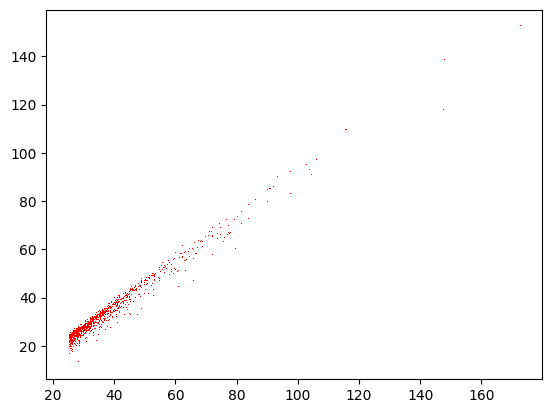

In [10]:
# These 2 cells are just testing Supercells by recalculating cluster ET and comparing

scVec = DFs[0]['SuperCell_ET']

TOB_ET = DFs[0]['TOB_ET']
eta = DFs[0]['TOB_eta']
ieta = DFs[0]['TOB_ieta']
phi = DFs[0]['TOB_phi']

# Build some additional variables from the supercells
emClus=np.zeros(scVec.size)
seedCell=np.zeros(scVec.size)
UnD=np.zeros(scVec.size)

# Not figured a listwise way of doing operations this complex, sadly
for roi in range(scVec.size):
    inputs = scVec[roi]
    emClus[roi],seedCell[roi],UnD[roi] = VariableMaker(inputs)

# Note: TOB_ET has "dead maperial corrections" applied, while emClus is from uncorrected supercells. 
# Hence don't expect perfect agreement
plt.plot(TOB_ET,emClus,'r,')

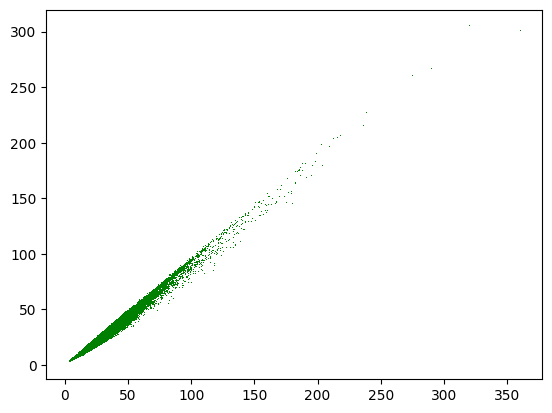

In [13]:
scVec = DFs[1]['SuperCell_ET']

TOB_ET = DFs[1]['TOB_ET']
eta = DFs[1]['TOB_eta']
ieta = DFs[1]['TOB_ieta']
phi = DFs[1]['TOB_phi']

# Build some additional variables from the supercells
emClus=np.zeros(scVec.size)
seedCell=np.zeros(scVec.size)
UnD=np.zeros(scVec.size)
clusUp = np.zeros(scVec.size)
clusDown = np.zeros(scVec.size)

# Not figured a listwise way of doing operations this complex, sadly
for roi in range(scVec.size):
    inputs = scVec[roi]
    emClus[roi],seedCell[roi], UnD[roi] = VariableMaker(inputs)
    if UnD[roi] > 0:
        clusUp[roi] = emClus[roi]
    else:
        clusDown[roi] = emClus[roi]
        
    '''
    if abs(TOB_ET[roi]-emClus[roi])/TOB_ET[roi] > 0.1:
        print("ET mismatch: eta = ",eta[roi],", iEta = ",ieta[roi]," seed = ",seedCell[roi],", TOB_ET = ",TOB_ET[roi],", reconstructed = ",emClus[roi])
    '''                

# Note: TOB_ET has "dead maperial corrections" applied, while emClus is from uncorrected supercells. 
# Hence don't expect perfect agreement
plt.plot(TOB_ET,emClus,'g,')

In [7]:
# Look at TopoClusters in signal sample relative to TOB

# Get some vectors from the signal dataframe
TOB_ET = DFs[1]['TOB_ET']
TOB_eta = DFs[1]['TOB_eta']
TOB_phi = DFs[1]['TOB_phi']
offline_ele_pt = DFs[1]['offline_ele_pt']
offline_ele_eta = DFs[1]['offline_ele_eta']
offline_ele_phi = DFs[1]['offline_ele_phi']
TopoCluster_ET = DFs[1]['TopoCluster_ET']
TopoCluster_eta = DFs[1]['TopoCluster_eta']
TopoCluster_phi = DFs[1]['TopoCluster_phi']

# Make some plots for all TCs
# And also find best-matched TC (in eta+phi)

# Quantities I'm going to plot later (all TCs)
TCETs = []
TCETFracs = []
TCDRs = []

# Quantities describing best-matched TC
Deta_TC = np.zeros(TOB_ET.size)
Dphi_TC = np.zeros(TOB_ET.size)
DR_TC = np.zeros(TOB_ET.size)
ET_TC = np.zeros(TOB_ET.size)
Frac_TC = np.zeros(TOB_ET.size)

# Loop over TOBs in dataset
for roi in range(TOB_ET.size):
    
    # Get TopoCluster information for this TOB
    TC_ET = TopoCluster_ET[roi]/1000.
    TC_eta = TopoCluster_eta[roi]
    TC_phi = TopoCluster_phi[roi]
    
    # Variables for best match
    DRTC = 1.
    ETTC = -1. # Could add these directly to result arrays but the -1 will tell me if nothing found
    DetaTC = -1
    DphiTC = -1
    FracTC = -1
    
    # Look at the clusters for this TOB
    for cl in range(len(TC_ET)):
        # Angular distance
        dEta = abs(TOB_eta[roi]-TC_eta[cl])
        dPhi = abs(TOB_phi[roi]-TC_phi[cl])
        if dPhi > np.pi:
            dPhi = 2*(np.pi - dPhi)
        dR = np.sqrt(dEta*dEta + dPhi*dPhi)

        # Things we want to plot for all TCs
        TCDRs.append(dR)
        TCETFracs.append(TC_ET[cl]/TOB_ET[roi])
        TCETs.append(TC_ET[cl])
        
        # Now look at best spatial matches of TopoClusters to TOBs
        # For best match study ignore insignificant or negative clusters
        if TC_ET[cl]<0.3: # Arbitrary choice of ET cut
            continue
            
        # Closest TC in angle
        if dR < DRTC:
            DRTC = dR
            DetaTC = dEta
            DphiTC = dPhi
            ETTC = TC_ET[cl]
            FracTC = ETTC/TOB_ET[roi]

    # Save results for best TC
    Deta_TC[roi] = DetaTC
    Dphi_TC[roi] = DphiTC
    DR_TC[roi] = DRTC
    ET_TC[roi] = ETTC
    Frac_TC[roi] = FracTC
    

# Now we've collected results, can make some plots

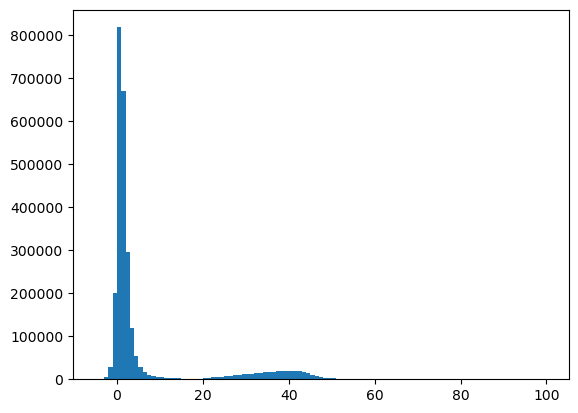

In [8]:
# Plot TC ET/TOB ET (all TCs)
plotData = plt.hist(TCETs,bins=105,range=(-5.,100.))

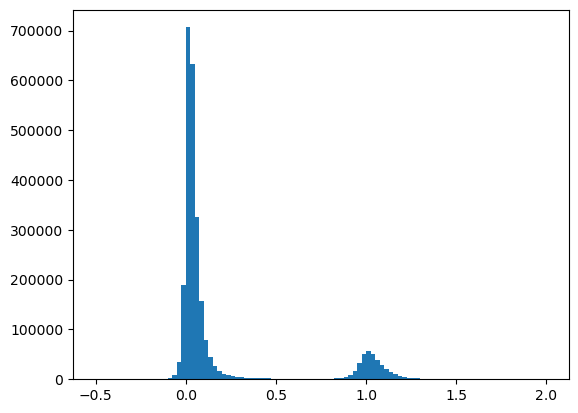

In [9]:
# Plot TC ET/TOB ET (all TCs)
plotData = plt.hist(TCETFracs,bins=100,range=(-0.5,2.))

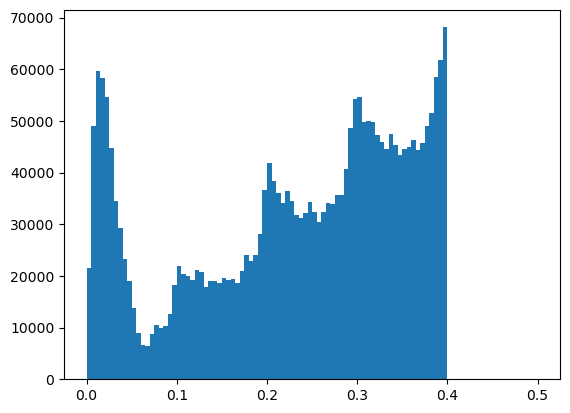

In [10]:
# Plot Delta(R) betwqeen TOB and TopoCluster (all TCs)
plotData = plt.hist(TCDRs,bins=100,range=(0.,0.5))

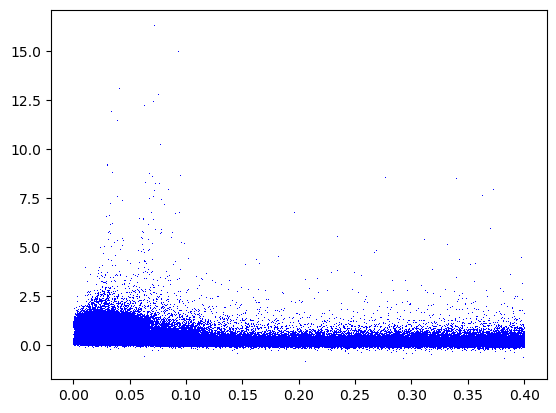

In [11]:
# Plot TC ET/TOB ET vs Delta(R) (all TCs)
plt.plot(TCDRs,TCETFracs,'b,')

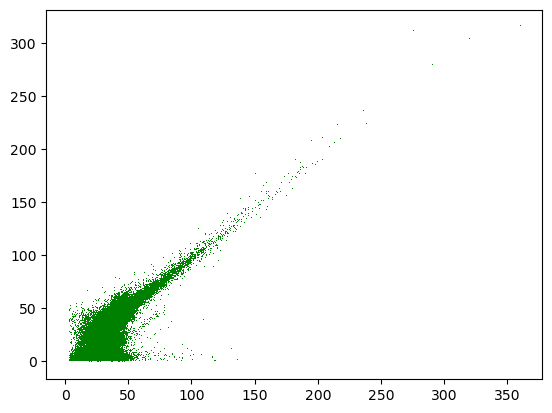

In [12]:
# Plot TopoCluster ET vs TOB ET (best-matched TCs)
plt.plot(TOB_ET,ET_TC,'g,')

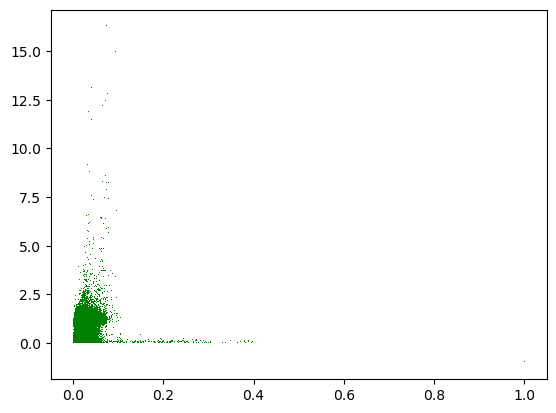

In [13]:
# Plot TC ET/TOB ET vs Delta(R) (best-matched TCs)
plt.plot(DR_TC,Frac_TC,'g,')

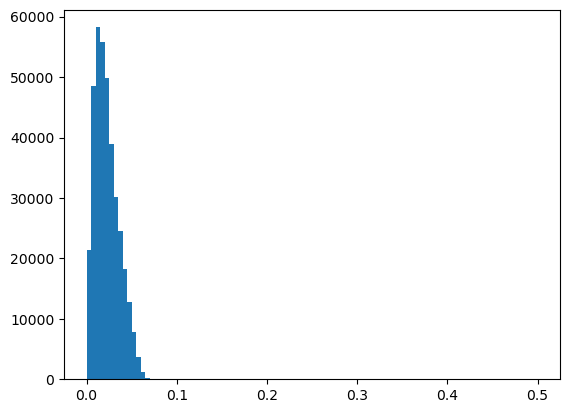

In [14]:
# Plot Delta(R) betwqeen TOB and TopoCluster (best-matches TC)
plotData = plt.hist(DR_TC,bins=100,range=(0.,0.5))

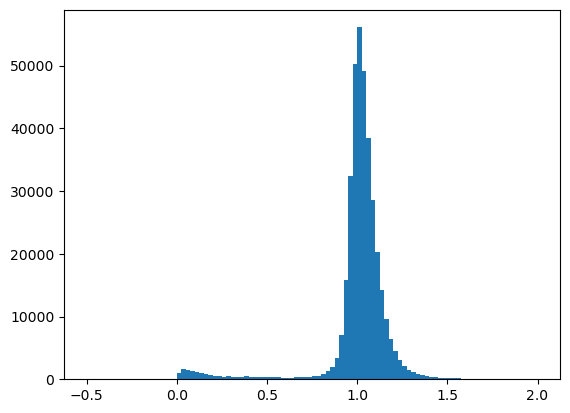

In [15]:
# Plot TC ET/TOB ET (best-matched TC)
plotData = plt.hist(Frac_TC,bins=100,range=(-0.5,2.))